In [725]:
%matplotlib inline

In [726]:
import tensorflow as tf
import numpy as np
import math
import keras
from keras import backend as K
from keras.layers import Activation
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.models import model_from_json
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
from sklearn import mixture
import math
from scipy import stats


In [68]:
train_path = os.getcwd()+'/data/train'
test_path = os.getcwd()+'/data/test'

#### Batches initialisation

In [69]:
train_batches = ImageDataGenerator().flow_from_directory(
    train_path, 
    target_size=(90,90),
    class_mode = "sparse", 
    color_mode="grayscale",
    classes=['slippers','sheareds','croissants'], 
    batch_size=128)

valid_batches = ImageDataGenerator().flow_from_directory(
    test_path, 
    target_size=(90,90),
    class_mode = "sparse", 
    color_mode="grayscale",
    classes=['slippers','sheareds','croissants'], 
    batch_size=128)

Found 7600 images belonging to 3 classes.
Found 400 images belonging to 3 classes.


In [5]:
train_batches.class_indices

{'slippers': 0, 'sheareds': 1, 'croissants': 2}

#### Data processing

In [70]:
type(train_batches[0][1][0])

numpy.float32

In [115]:
train_batches[0][0].shape

(128, 90, 90, 1)

>imshow() ne prends que des array 2D ou 3D avec 3eme dimension =3-4

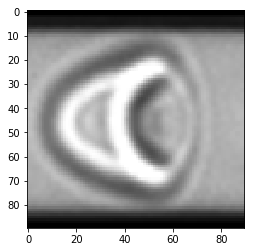

In [165]:
plt.imshow(train_batches[0][0][9].squeeze(),cmap="gray")

Taille de chaque image : (90,90,1) : img.squeeze() => (90,90)

In [216]:
train_batches[0][0][9]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[2.],
        [2.],
        [2.],
        ...,
        [2.],
        [2.],
        [2.]],

       [[6.],
        [6.],
        [6.],
        ...,
        [7.],
        [7.],
        [7.]],

       ...,

       [[3.],
        [3.],
        [3.],
        ...,
        [3.],
        [3.],
        [3.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)

In [167]:
type(train_batches[0][0][9])

numpy.ndarray

In [168]:
train_batches[0][0].shape

(128, 90, 90, 1)

#### Implémentation du Modèle

In [6]:
# Number of classes
num_classes = 3
## Model 
## 3 couches de convolutions
cnn_model = Sequential()

cnn_model.add(Conv2D(25, kernel_size=(21, 21),activation=None,input_shape=(90,90,1)))
cnn_model.add(BatchNormalization(epsilon=1e-5))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D((2, 2),strides=2))

cnn_model.add(Conv2D(32, (11, 11), activation=None))
cnn_model.add(BatchNormalization(epsilon=1e-5))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

cnn_model.add(Conv2D(64, (3, 3), activation=None))
cnn_model.add(BatchNormalization(epsilon=1e-5))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

## On écrase les matrices en vecteurs
cnn_model.add(Flatten())
## Couche fully-connected                  
## Couche de regression (à check pour la fonction d'activation linéaire)
cnn_model.add(Dense(1, activation='linear'))

Instructions for updating:
Colocations handled automatically by placer.


>Couche Relu après le layer 3 de convolution non  présent dans le code mais précisé dans l'article (tableau d'overview du modèle)

In [7]:
from keras import optimizers
sgdm = optimizers.SGD(lr=0.001, momentum=0.9,nesterov=False)

In [8]:
### Compile model
cnn_model.compile(
    loss='mean_squared_error', 
    optimizer=sgdm,
    metrics=['mse', 'mae']
)

In [9]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 70, 70, 25)        11050     
_________________________________________________________________
batch_normalization_1 (Batch (None, 70, 70, 25)        100       
_________________________________________________________________
activation_1 (Activation)    (None, 70, 70, 25)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 25)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        96832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 25, 25, 32)        0         
__________

In [10]:
batch_size=128
step_train = math.ceil(len(train_batches.filenames) / batch_size)
step_valid = math.ceil(len(valid_batches.filenames)/batch_size)
print(step_train)
print(step_valid)

60
4


*Paramètres à initialiser pour fit_generator*
https://keras.io/models/sequential/

steps_per epoch = ceil(num_samples / batch_size)

In [11]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))


historyPerBatch = LossHistory()

cnn_train = cnn_model.fit_generator(train_batches, 
    steps_per_epoch=step_train, 
    epochs=12,
    verbose=1,
    validation_data=valid_batches,
    validation_steps=step_valid,
    callbacks = [historyPerBatch]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
60/60 [==============================] - 725s 12s/step - loss: 1.3636 - mean_squared_error: 1.3636 - mean_absolute_error: 0.7048 - val_loss: 0.4195 - val_mean_squared_error: 0.4195 - val_mean_absolute_error: 0.5771
Epoch 2/15
60/60 [==============================] - 677s 11s/step - loss: 0.0623 - mean_squared_error: 0.0623 - mean_absolute_error: 0.1938 - val_loss: 0.0445 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1690
Epoch 3/15
60/60 [==============================] - 697s 12s/step - loss: 0.0436 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1589 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1155
Epoch 4/15
60/60 [==============================] - 694s 12s/step - loss: 0.0286 - mean_squared_error: 0.0286 - mean_absolute_error: 0.1247 - val_loss: 0.0441 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1734
Epoch 5/15
60/60 [==============================

In [7]:
from keras.models import model_from_json

model_json = cnn_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn_model.save_weights("model.h5")

NameError: name 'cnn_train' is not defined

In [180]:
cnn_model.save("cnn_model_v1.h5")

https://machinelearningmastery.com/save-load-keras-deep-learning-models/

Epoch 1/12
60/60 [==============================] - 668s 11s/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0878 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0830
Epoch 2/12
60/60 [==============================] - 560s 9s/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0871 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1192
Epoch 3/12
60/60 [==============================] - 536s 9s/step - loss: 0.0181 - mean_squared_error: 0.0181 - mean_absolute_error: 0.1026 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0787
Epoch 4/12
60/60 [==============================] - 665s 11s/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0890 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0962
Epoch 5/12
60/60 [==============================] - 673s 11s/step - loss: 0.0129 - mean_squared_er

In [1]:
#### Plot rmse = sqrt(mse)
mse = cnn_train.history['mean_squared_error']
val_mse = cnn_train.history['val_mean_squared_error']
loss = cnn_train.history['loss']
val_loss = cnn_train.history['val_loss']
epochs = range(len(mse))
plt.plot(np.linspace(0,12,len(historyPerBatch.losses)), np.sqrt(historyPerBatch.losses), 'r', label='Training rmse')
plt.plot(epochs, np.sqrt(val_mse), 'o', label='Validation rmse')
plt.title('Training and validation rmse')
plt.legend()
plt.yscale('log')

plt.figure()
plt.plot(np.linspace(0,12,len(historyPerBatch.losses)), historyPerBatch.losses, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'o', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.yscale('log')

plt.show()

NameError: name 'cnn_train' is not defined

#### Resultats d'entrainement

In [186]:
batch_size = 128
len_sample = np.ceil(len(train_batches.filenames)/batch_size)
print(len_sample)

60.0


In [187]:
predicted_train = cnn_model.predict_generator(train_batches,steps=len_sample, verbose=1)

60/60 [==============================] - 147s 2s/step


>steps: Total number of steps (batches of samples) to yield from generator before stopping. 

Or dans le code MatLab, la prediction est faite sur chaque image.

In [188]:
predicted_train.shape

(7600, 1)

In [189]:
print("len : ", len(predicted_train))
print("min : ",np.amin(predicted_train))
print("max : ",np.amax(predicted_train))

len :  7600
min :  -0.31468868
max :  2.5997162


(array([  8.,  53., 350., 960., 760., 455., 172.,  37.,   9.,   8.,   5.,
          7.,   4.,   7.,  27.,  42., 147., 306., 429., 391., 309., 181.,
         72.,  52.,  58.,  88., 151., 284., 521., 579., 487., 343., 177.,
         94.,  21.,   6.]),
 array([-0.31468868, -0.233733  , -0.1527773 , -0.07182161,  0.00913408,
         0.09008977,  0.17104547,  0.25200117,  0.33295685,  0.41391253,
         0.49486822,  0.5758239 ,  0.6567796 ,  0.7377353 ,  0.818691  ,
         0.8996467 ,  0.9806024 ,  1.061558  ,  1.1425138 ,  1.2234695 ,
         1.3044251 ,  1.3853809 ,  1.4663365 ,  1.5472922 ,  1.6282479 ,
         1.7092036 ,  1.7901592 ,  1.871115  ,  1.9520707 ,  2.0330265 ,
         2.113982  ,  2.1949377 ,  2.2758934 ,  2.3568492 ,  2.4378047 ,
         2.5187604 ,  2.5997162 ], dtype=float32),
 <a list of 36 Patch objects>)

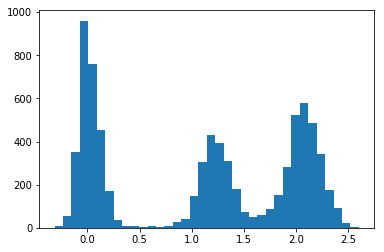

In [190]:
plt.hist(predicted_train, bins=int(180/5))  

OldRange = (OldMax - OldMin)  
NewRange = (NewMax - NewMin)  
NewValue = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin

In [191]:
predicted_train = ((predicted_train - np.amin(predicted_train))*254)/(np.amax(predicted_train)-np.amin(predicted_train)) - 127

(array([  3.,   2.,   8.,  11.,  37.,  79., 153., 248., 429., 401., 320.,
        314., 249., 188., 144.,  95.,  57.,  31.,  16.,  10.,   5.,   3.,
          3.,   4.,   2.,   2.,   2.,   6.,   0.,   2.,   1.,   2.,   3.,
          0.,   5.,   3.,  10.,  20.,  18.,  18.,  50.,  55.,  77., 130.,
        141., 190., 152., 180., 146., 152., 148., 121.,  84.,  71.,  66.,
         28.,  25.,  35.,  21.,  15.,  16.,  28.,  28.,  40.,  34.,  53.,
         56.,  89., 125., 112., 178., 210., 253., 235., 224., 213., 180.,
        164., 152., 121.,  77.,  64.,  66.,  42.,  22.,  13.,   4.,   6.,
          1.,   3.]),
 array([-1.27000000e+02, -1.24177780e+02, -1.21355553e+02, -1.18533333e+02,
        -1.15711113e+02, -1.12888885e+02, -1.10066666e+02, -1.07244446e+02,
        -1.04422226e+02, -1.01599998e+02, -9.87777786e+01, -9.59555588e+01,
        -9.31333313e+01, -9.03111115e+01, -8.74888916e+01, -8.46666641e+01,
        -8.18444443e+01, -7.90222244e+01, -7.61999969e+01, -7.33777771e+01,
      

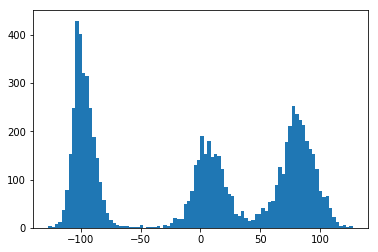

In [192]:
plt.hist(predicted_train, bins=int(180/2))
#Pour avoir la jolie courbe de distribution de l'histogramme : voir modue seaborn (kde)

#### Résultats sur le valid_test

#### Fit gaussiennes (à faire)

#### Evaluation du modèle (sur le test_batches) (remove)

In [51]:
len(test_batches[0][0])

10

In [52]:
test_batches[0][0][0].shape

(90, 90, 1)

In [457]:
#boucles pour les imgs
t_imgs = []
for i in range(len(test_batches)):
    for j in range(len(test_batches[0][0])):
        label = test_batches[i][1][j]
        t_imgs.append([test_batches[i][0][j],label])

test_imgs = np.array([i[0] for i in t_imgs])

In [458]:
#boucles pour les labels
t_labels = []
for i in range(len(test_batches)):
    for j in range(len(test_batches[0][0])):
        t_labels.append(np.array(test_batches[i][1][j]))

test_labels = np.asarray(t_labels)

In [459]:
test_eval = cnn_model.evaluate(test_imgs, test_labels, batch_size = 10, verbose=1)

400/400 [==============================] - 18s 44ms/step


In [476]:
print("%s: %.2f%%" % (cnn_model.metrics_names[0], test_eval[0]*100))
print("%s: %f" % (cnn_model.metrics_names[1], test_eval[1]))
print("%s: %f" % (cnn_model.metrics_names[2], test_eval[2]))

loss: 3.84%
mean_squared_error: 0.038373
mean_absolute_error: 0.137259


### Prédiction et  Evaluation du modèle (jeu de test : input_data)

In [3]:
# load json and create model
json_file = open('model80.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model80.h5")
print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Loaded model from disk


In [113]:
pathdir = "measurements/"
path = os.listdir("measurements")

In [114]:
path

['001_Crop_Pics_w_parameters_20mbar',
 '002_Crop_Pics_w_parameters_50mbar',
 '003_Crop_Pics_w_parameters_100mbar',
 '004_Crop_Pics_w_parameters_200mbar',
 '005_Crop_Pics_w_parameters_300mbar',
 '006_Crop_Pics_w_parameters_400mbar',
 '007_Crop_Pics_w_parameters_500mbar',
 '008_Crop_Pics_w_parameters_600mbar',
 '009_Crop_Pics_w_parameters_700mbar',
 '010_Crop_Pics_w_parameters_800mbar',
 '011_Crop_Pics_w_parameters_900mbar',
 '012_Crop_Pics_w_parameters_1000mbar']

In [115]:
from os.path import isfile, join
images_test = []
images_labels = []
for directory in path:
    sub_directory = os.listdir("measurements/"+directory)
    print(sub_directory)

['Croissants', 'Others']
['Croissants', 'Others']
['Croissants', 'Others', 'Slippers']
['Croissants', 'Others', 'Slippers']
['Croissants', 'Others', 'Slippers']
['Croissants', 'Others', 'Slippers']
['Croissants', 'Others', 'Slippers']
['Croissants', 'Others', 'Slippers']
['Others', 'Slippers']
['Others', 'Slippers']
['Croissants', 'Others', 'Slippers']
['Others', 'Slippers']


In [116]:
from PIL import Image
import cv2

images_test = []
labels_test = []
for subdir, dirs, files in os.walk(pathdir):
        category_name = os.path.basename(subdir)
        #print(category_name)
        #print(files)
        if files == []:
            root_dir = category_name
        else :
            print(len(files))
            for img in files:
                new_path =os.path.join(pathdir,root_dir,category_name,img)
                im=Image.open(new_path)
                img_array = np.reshape(np.array(im),(-1,90,90))
                images_test.append(img_array)
                labels_test.append(np.array(category_name))


9
98
9
43
165
38
2
252
210
22
102
253
120
80
216
167
17
81
117
8
44
124
18
105
31
169
2
39
241
39
269


#### R=Verif shape - scale

In [13]:
images_test[0].squeeze()

array([[ 55,  55,  53, ...,  48,  48,  48],
       [ 67,  67,  65, ...,  61,  62,  62],
       [ 79,  79,  77, ...,  73,  76,  77],
       ...,
       [ 96,  96,  96, ...,  61,  61,  61],
       [138, 138, 138, ...,  94,  95,  96],
       [179, 179, 178, ..., 133, 135, 136]], dtype=uint8)

In [183]:
print(np.amax(images_test))
print(np.amin(images_test))

255
24


In [41]:
images_test[0].shape

(1, 90, 90)

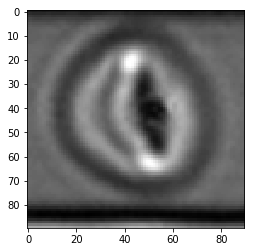

In [117]:
plt.imshow(images_test[0].squeeze(), cmap="gray")

### Image pre-processing

In [184]:
images_copy = images_test 

In [203]:
from scipy import signal
window= signal.tukey(90,0.25)
window = np.tile(win,(1,90))
window = np.reshape(window,(90,90,-1))
window = window.T

In [209]:
out_tuckey = window.squeeze()*images_copy[0].squeeze()

In [137]:
out_tuckey = np.multiply(window.squeeze(),images_copy[0].squeeze())

In [195]:
out_tuckey *= 255.0/out_tuckey.max() 

In [200]:
out_tuckey.shape

(90, 90)

In [222]:
### imdj2 ?
out = (out_tuckey.squeeze() - 1) * (255 / (99 - 1))
#out = np.clip(out, 0, 255, out)

In [213]:
import bisect

def imadjust(src, tol=1, vin=[0,255], vout=(0,255)):
    # src : input one-layer image (numpy array)
    # tol : tolerance, from 0 to 100.
    # vin  : src image bounds
    # vout : dst image bounds
    # return : output img

    dst = src.copy()
    tol = max(0, min(100, tol))

    if tol > 0:
        # Compute in and out limits
        # Histogram
        hist = np.zeros(256, dtype=np.int)
        for r in range(src.shape[0]):
            for c in range(src.shape[1]):
                hist[src[r,c]] += 1
        # Cumulative histogram
        cum = hist.copy()
        for i in range(1, len(hist)):
            cum[i] = cum[i - 1] + hist[i]

        # Compute bounds
        total = src.shape[0] * src.shape[1]
        low_bound = total * tol / 100
        upp_bound = total * (100 - tol) / 100
        vin[0] = bisect.bisect_left(cum, low_bound)
        vin[1] = bisect.bisect_left(cum, upp_bound)

    # Stretching
    scale = (vout[1] - vout[0]) / (vin[1] - vin[0])
    for r in range(dst.shape[0]):
        for c in range(dst.shape[1]):
            vs = max(src[r,c] - vin[0], 0)
            vd = min(int(vs * scale + 0.5) + vout[0], vout[1])
            dst[r,c] = vd
    return dst    

In [214]:
out3 = imadjust(img)

(Text(0.5, 1.0, ' After Imadj'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

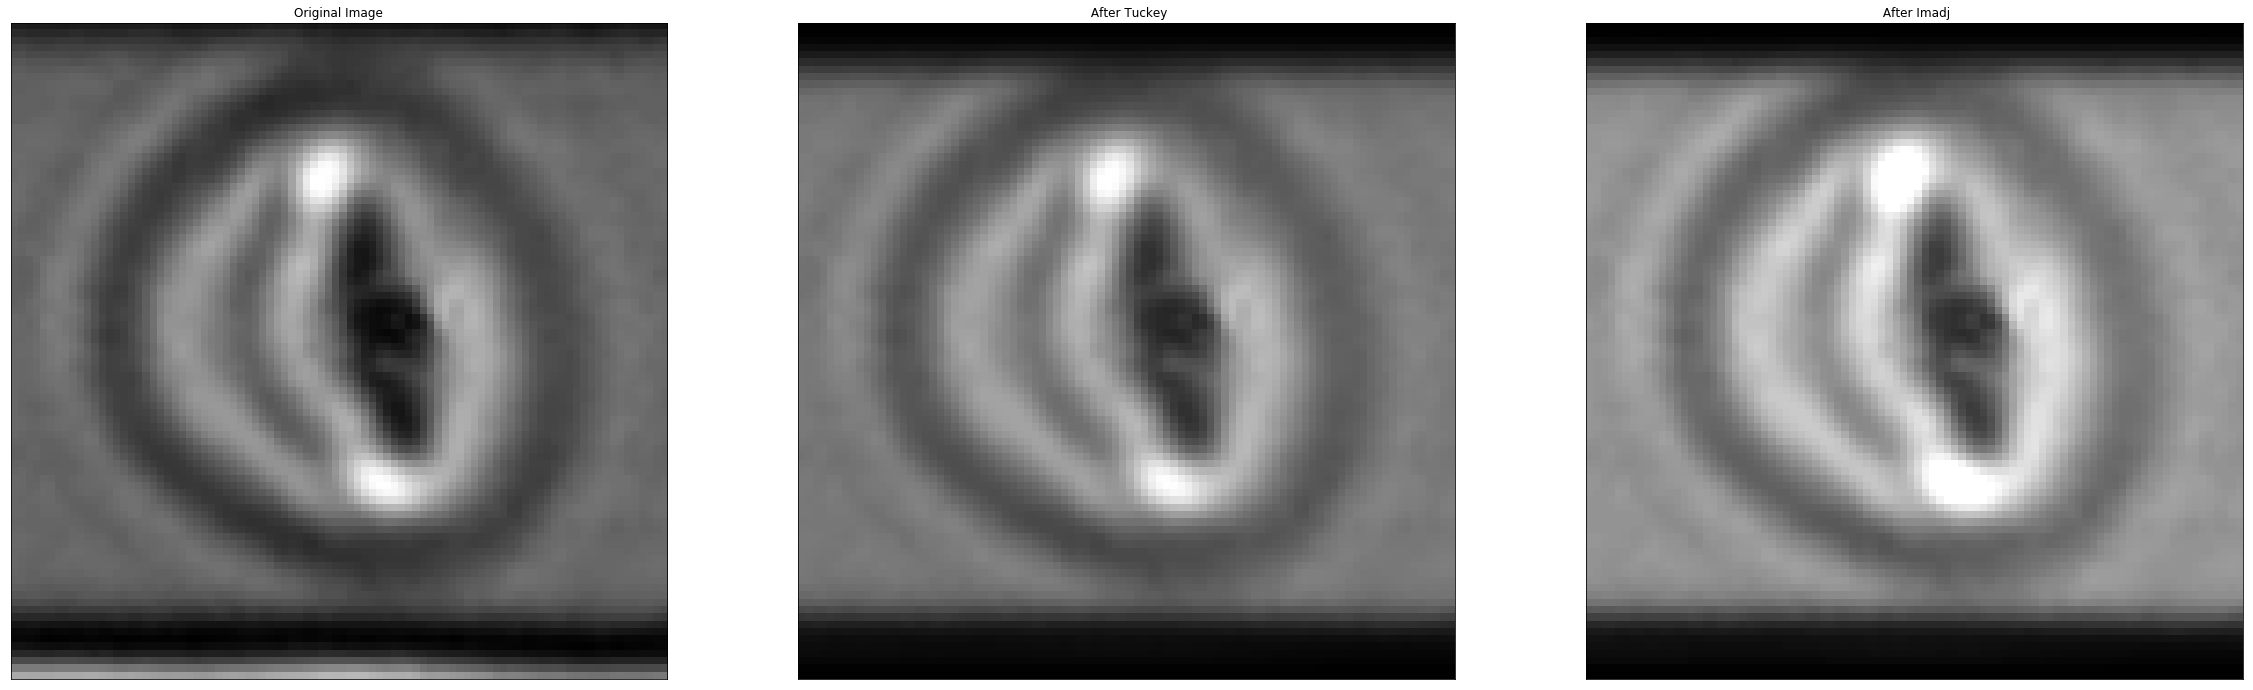

In [229]:
fig = plt.figure(figsize=(40, 40))
plt.subplot(131)
plt.imshow(images_test[0].squeeze(), cmap="gray")
plt.title('Original Image')

plt.subplot(132)
plt.imshow(out_tuckey, cmap="gray")
plt.title(' After Tuckey'), plt.xticks([]), plt.yticks([],fontsize=24)

plt.subplot(133)
plt.imshow(out3, cmap="gray")
plt.title(' After Imadj'), plt.xticks([]), plt.yticks([])


* train_batches.astype(int) ??

In [293]:
from scipy import signal
window= signal.tukey(90,0.25)
window = np.tile(win,(1,90))
window = np.reshape(window,(90,90,-1))
window = window.T

images_process = []

for img in images_test:
    out_tuckey = window.squeeze()*img.squeeze()
    out_tuckey *= 255.0/out_tuckey.max() 
    out_tuckey = out_tuckey.astype(int)
    out_adj = imadjust(out_tuckey)
    out_adj = np.reshape(np.array(out_adj),(-1,90,90,1))
    images_process.append(out_adj)


#### Prediction

In [269]:
images_pro = np.array(images_process)

In [288]:
images_test[0].shape

(1, 90, 90)

In [294]:
from keras import optimizers
sgdm = optimizers.SGD(lr=0.001, momentum=0.9,nesterov=False)
loaded_model.compile(
    loss='mean_squared_error', 
    optimizer=sgdm,
    metrics=['mse', 'mae']
)

In [296]:
predicted_test = []
for img in images_process:
    predicted = loaded_model.predict(img,batch_size=1,verbose=0)
    predicted_test.append(predicted)

In [297]:
copy_predicted = predicted_test

OldRange = (OldMax - OldMin)  
NewRange = (NewMax - NewMin)  
NewValue = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin

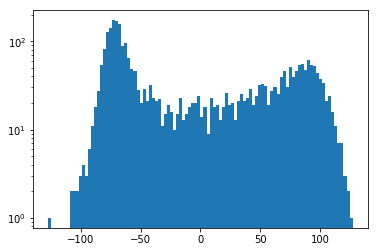

In [298]:
predicted_test= np.reshape(np.array(predicted_test),(3090,1))
predicted_test = ((predicted_test - np.amin(predicted_test))*254)/(np.amax(predicted_test)-np.amin(predicted_test)) - 127
plt.hist(predicted_test, bins=100)
plt.yscale('log')

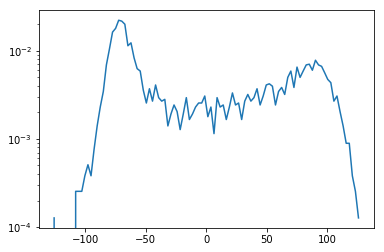

In [299]:
y,binEdges=np.histogram(predicted_test,bins=100, density=True)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-')
plt.yscale('log')
plt.show()

#### Fit histogramme par Mixture Gaussienne

In [301]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
# plt.plot(bincenters,y)
# y_smooth = smooth(y,3)
# plt.plot(bincenters_train, smooth(y,3), 'r-', lw=1)
# plt.yscale('log')

[0.25078948 0.12642449 0.10112339 0.10777188 0.17455701 0.09510066
 0.14423309]
[[-73.99338075]
 [ 75.43012067]
 [  4.63296916]
 [ 44.95667585]
 [-66.78769429]
 [-38.59137872]
 [ 95.51232409]]
[[[ 75.82226847]]

 [[117.66311674]]

 [[252.82721339]]

 [[169.52497722]]

 [[ 56.50731844]]

 [[176.19954043]]

 [[111.53558265]]]


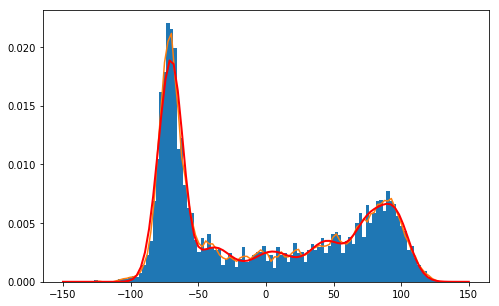

In [901]:
from sklearn import mixture


# gmm = mixture.GaussianMixture(n_components=3, covariance_type='spherical')
gmm = mixture.GaussianMixture(n_components=7)
g = gmm.fit(predicted_test)

weights = g.weights_
means = []
means = g.means_
covars = g.covariances_


print(weights)
print(means)
print(covars)

gmm_x = np.linspace(-150, 150, 100)
#gmm_y = gauss_function(gmm_x,0.001,means[0],np.sqrt(covars[0]))
gmm_y = np.exp(g.score_samples(gmm_x.reshape(-1,1)))
gmm_y=np.reshape(gmm_y,(-1,1))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8, 5])
#y2=y/100
ax.hist(predicted_test, bins=100,density=True)
ax.plot(bincenters,smooth(y,3))
#ax.plot(bincenters,y2,'-')
#plt.yscale('log')
ax.plot(gmm_x, gmm_y, color="red", lw=2, label="GMM")

* Utiliser quatre gaussiennes est pertinent

In [902]:
meanSl = min(means)[0]
meanCr = max(means)[0]

varSli = covars[np.where(means == min(means))][0][0]
varCr = covars[np.where(means == max(means))][0][0]
print(meanSl)
print(meanCr)

-73.9933807539625
95.51232408956093


### Intervalle de confiance

In [903]:
import math
from scipy import stats

paramSli = [(meanSl), (math.sqrt(varSli))]
paramCr = [(meanCr), (math.sqrt(varCr))]

#n = len(predicted_test)

sl = math.sqrt(varSli)
sC = math.sqrt(varCr)


intervalSli = []
intervalSli.append(meanSl-3.2*sl)
intervalSli.append(meanSl+3.2*sl)
intervalCr = []
intervalCr.append(meanCr-2.6*sC)
intervalCr.append(meanCr+2.6*sC)

#intervalSli = stats.norm.interval(alpha = 0.95, loc=paramSli[0], scale=paramSli[1])
#intervalCr = stats.norm.interval(alpha = 0.95, loc=paramCr[0], scale=paramCr[1])



print(intervalCr)
# print(intervalSh)
print(intervalSli)
print(sl)
meanSl = min(means)[0]
meanCr = max(means)[0]



[68.0536180252659, 122.97103015385596]
[-101.85769537274048, -46.129066135184516]
8.707598318368118


In [904]:
true_labels = []
for i in range(len(labels_test)):
    if(labels_test[i] == 'Slippers'):
        true_labels.append(0)
    elif(labels_test[i] == 'Croissants'):
        true_labels.append(2)
    else : 
        true_labels.append(1)

true_labels = np.asarray(true_labels)

In [905]:
true_labels

array([2, 2, 2, ..., 0, 0, 0])

In [906]:
### Confusion matrix
predicted_test
### Confidence interval to put the results in their ranged classes

## here the predicted numbers we modify to fit with the numeric labels (0,1,2)

pred_labels = []

for k in range(len(predicted_test)):
    #if((predicted_test[k]>intervalCr[0])*(predicted_test[k]<intervalCr[1])): #Croissants
    if((predicted_test[k]>intervalCr[0])): #Croissants

        pred_labels.append(2)
    #elif((predicted_test[k]>intervalSli[0])*(predicted_test[k]<intervalSli[1])): #Slippers
    elif((predicted_test[k]<intervalSli[1])): #Slippers

        pred_labels.append(0)
    else: 
        pred_labels.append(1) #Other : if they fit in no confidence interval, we assume they are just "others"

pred_labels = np.asarray(pred_labels)



In [899]:
# Credit to github/hitvoice
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)

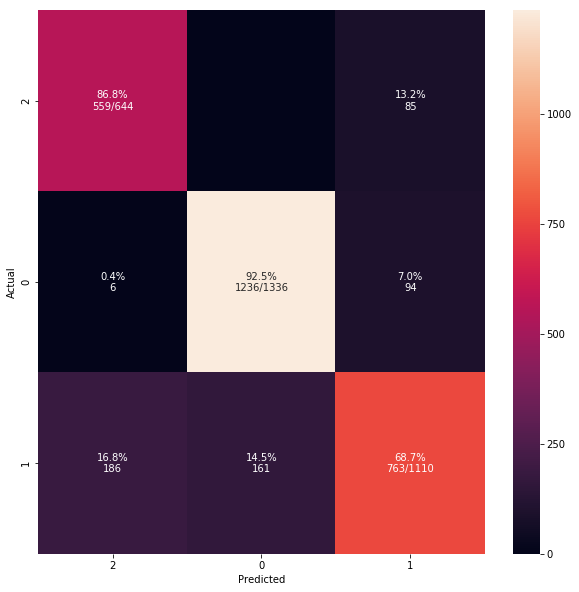

In [907]:
#g=7 best Accuracy
cm_analysis(true_labels, pred_labels, labels = [2,0,1])

cm_analysis(true_labels, pred_labels, labels = [2,0,1])

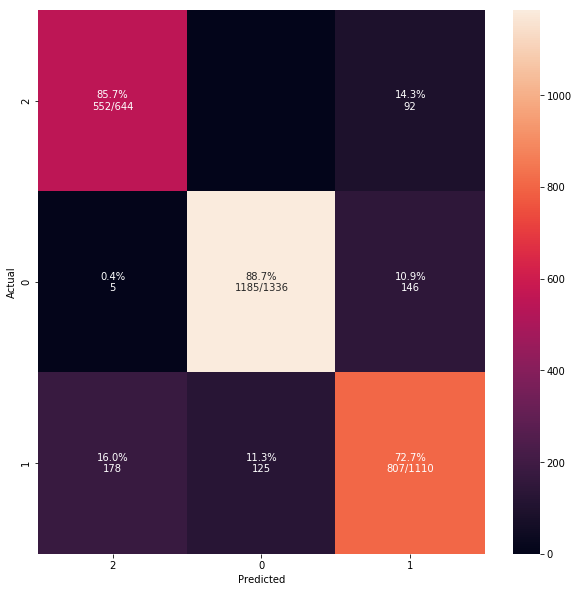

In [380]:
#Ic article 2sig, g=6
cm_analysis(true_labels, pred_labels, labels = [2,0,1])

cm_analysis(true_labels, pred_labels, labels = [2,0,1])

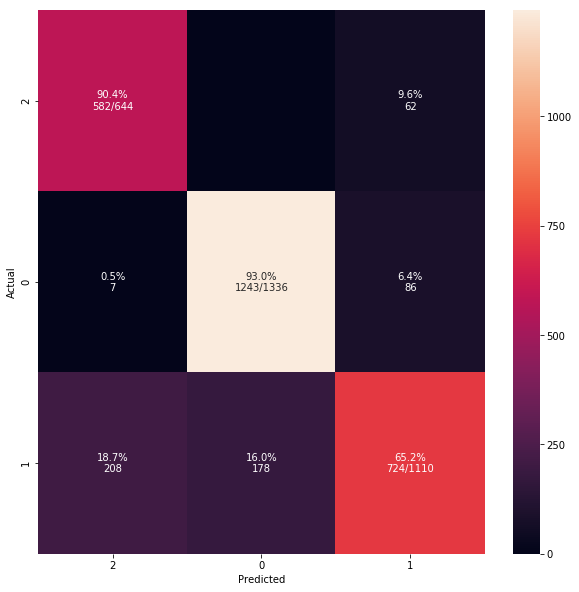

In [631]:
# Ic adapted 2sig / 3sig g = 5
cm_analysis(true_labels, pred_labels, labels = [2,0,1])

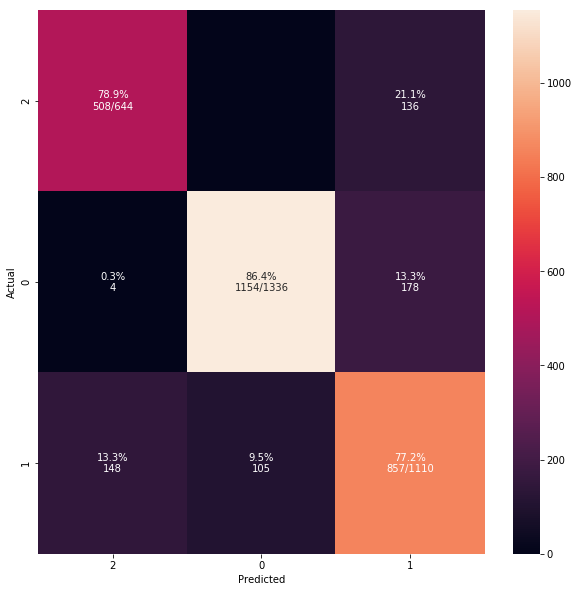

In [652]:
#Ic adapted g=7
cm_analysis(true_labels, pred_labels, labels = [2,0,1])

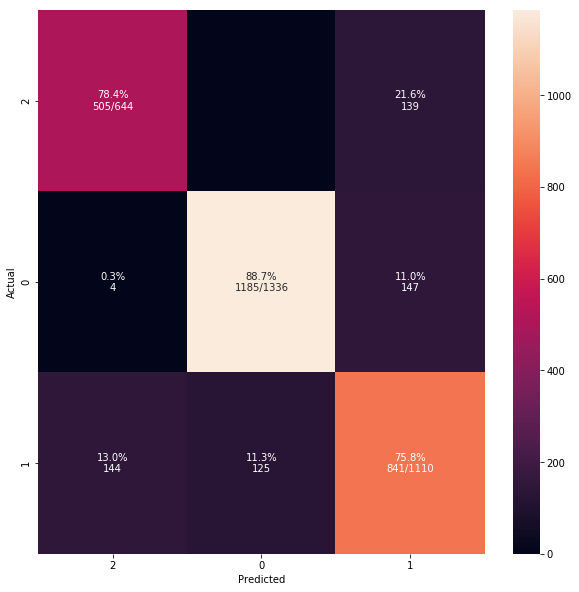

In [438]:
#Ic article 2sig g=5
cm_analysis(true_labels, pred_labels, labels = [2,0,1])

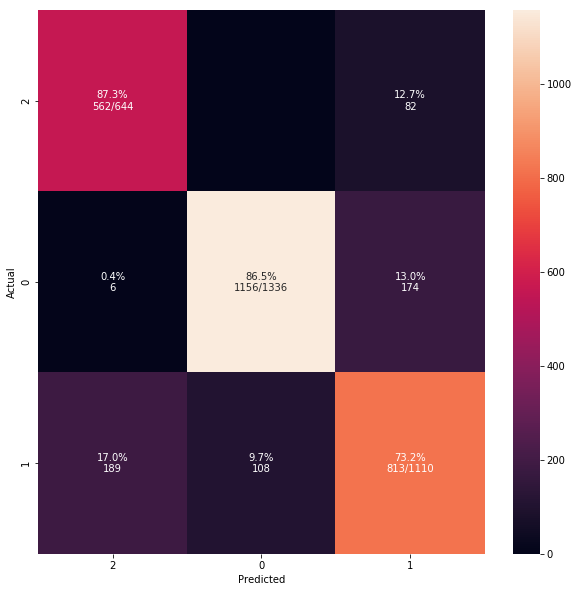

In [366]:
#0.95 g=6
cm_analysis(true_labels, pred_labels, labels = [2,0,1])

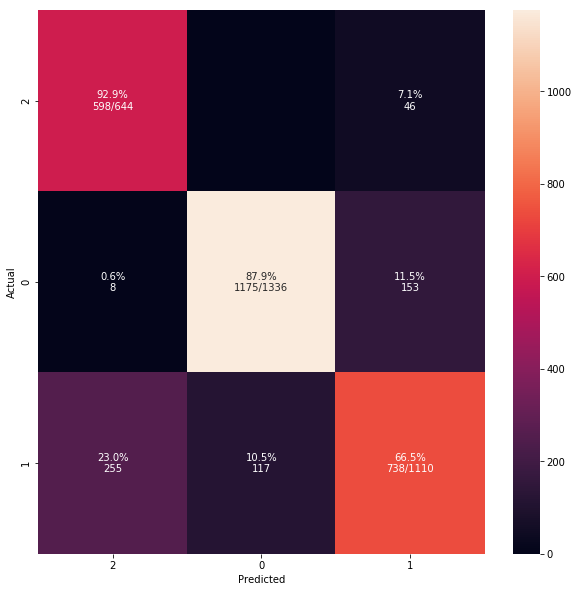

In [456]:
#ic 0.95 g=4
cm_analysis(true_labels, pred_labels, labels = [2,0,1])

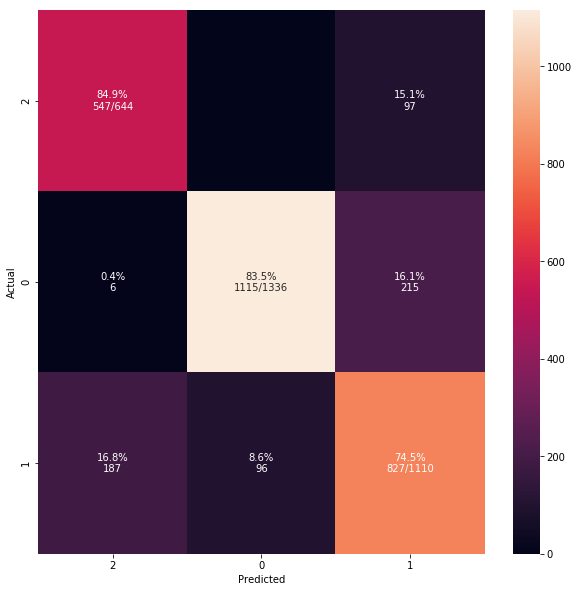

In [352]:
#IC 0.95 with borne g=6
cm_analysis(true_labels, pred_labels, labels = [2,0,1])

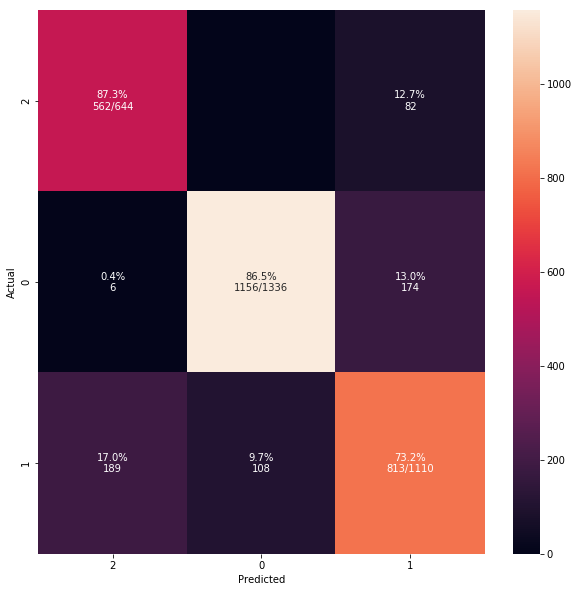

In [347]:
cm_analysis(true_labels, pred_labels, labels = [2,0,1])

In [356]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
## F1 score
f1 = f1_score(true_labels, pred_labels, 
                         labels=[0,1,2], 
                         pos_label=1, 
                         average=None, 
                         sample_weight=None)

In [357]:
## Precision and recall
pres_recall = precision_recall_fscore_support(true_labels, pred_labels, 
                                beta=1.0, 
                                labels=[0,1,2], 
                                pos_label=1, 
                                average=None, 
                                warn_for=('precision', 'recall', 'f-score'), 
                                sample_weight=None)

precision = pres_recall[0]
recall = pres_recall[1]
print(f1, precision, recall)

[0.87553985 0.73543797 0.79046243] [0.92072667 0.7260755  0.73918919] [0.83458084 0.74504505 0.84937888]


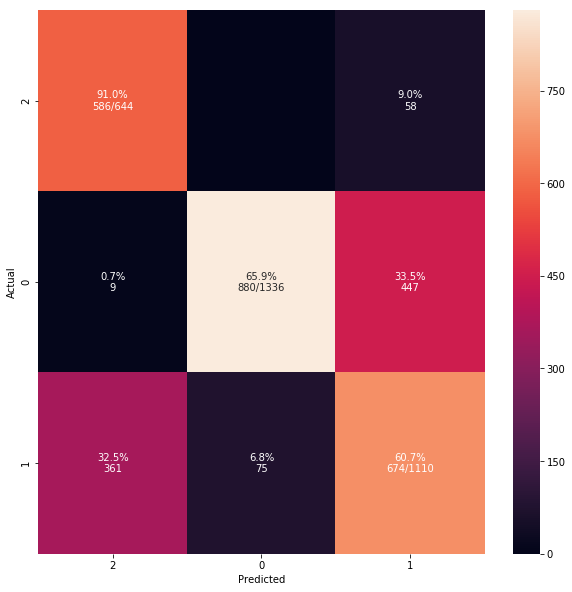

In [278]:
cm_analysis(true_labels, pred_labels, labels = [2,0,1])

* Intervalle de confiance à 68% en supprimant les borne inf (slippears) et sup (croissants) 

#### Analyse d'erreurs

>And further, the weight initialization of layers might be different. For example, by default the glorot_uniform (i.e. uniform distribution) is used for kernel initialization of Dense layer in Keras, whereas in MATLAB Gaussian distribution with mean 0 and standard deviation 0.01 is used for initializing weights of fullyConnectedLayer

* mettre l'erreur  par rapport à une erreur de référence
* Variabilité la même de la même à la fin
* études parallèles du % précision enfonction du nombre de gaussienne/choix de $\sigma$
    * trouver nombre de gaussiennes optimal
    * -> 8
    * graphes selon paramètres choisi / table

### Recherche optimum

In [581]:
def gmmAnalyisMisclass(predicted_test, labels_test,alphaSigma):
    result = []
    for k in range(3,13):        
        ## GMM
        gmm = mixture.GaussianMixture(n_components=k)
        g = gmm.fit(predicted_test)
        weights = g.weights_
        means = []
        means = g.means_
        covars = g.covariances_
        meanSl = min(means)[0]
        meanCr = max(means)[0]
        varSli = covars[np.where(means == min(means))][0][0]
        varCr = covars[np.where(means == max(means))][0][0]
        
        ## We got then the confidence interval
        paramSli = [(meanSl), (math.sqrt(varSli))]
        paramCr = [(meanCr), (math.sqrt(varCr))]
        sl = alphaSigma*math.sqrt(varSli)
        sC = alphaSigma*math.sqrt(varCr)
        intervalSli = []
        intervalSli.append(meanSl-sl)
        intervalSli.append(meanSl+sl)
        intervalCr = []
        intervalCr.append(meanCr-sC)
        intervalCr.append(meanCr+sC)
        ## predictions
        pred_labels = []

        for i in range(len(predicted_test)):
            if((predicted_test[i]>intervalCr[0])): #Croissants
                pred_labels.append(2)
            elif((predicted_test[i]<intervalSli[1])): #Slippers
                pred_labels.append(0)
            else: 
                pred_labels.append(1) #Other : if they fit in no confidence interval, we assume they are just "others"

        pred_labels = np.asarray(pred_labels)

        
        
        ## true labels
        true_labels = []
        for i in range(len(labels_test)):
            if(labels_test[i] == 'Slippers'):
                true_labels.append(0)
            elif(labels_test[i] == 'Croissants'):
                true_labels.append(2)
            else : 
                true_labels.append(1)

        true_labels = np.asarray(true_labels)
        
        
        
        #cm = confusion_matrix(y_true, y_pred, labels=labels)

        
        cm = confusion_matrix(true_labels, pred_labels, labels=[2, 0, 1])
                
        
        ## critères de perf
        
        tp = 0
        err = 0
        
        for i in range(len(cm)):
            for j in range(len(cm)):
                if i==j:
                    tp = cm[i][j] + tp
                else:
                    err = err + cm[i][j]
            
        
        acc_rate = tp /np.sum(cm)
        err_rate = err/np.sum(cm)
        
        
        res_acc = precision_recall_fscore_support(true_labels, pred_labels, 
                                beta=1.0, 
                                labels=[2,0,1], 
                                pos_label=1, 
                                average=None, 
                                warn_for=('precision', 'recall', 'f-score'), 
                                sample_weight=None)

        precision = res_acc[0]
        recall = res_acc[1]
        f1 = res_acc[2]
        gmm_res = []
        gmm_res.append([acc_rate,err_rate])
        for i in range(3):
                #gmm_res.append(recall[i])

                gmm_res.append([precision[i],recall[i],f1[i]])
        result.append(gmm_res)     
        
        
    return result

In [419]:
#result[k]
#(g=4)[[acc,err] -->result[k][0]
#(cr)[pres,recall,f1] -->result[k][1]
#(sl)[pres,recall,f1] -->result[k][2]
#(oth)[pres,recall,f1]] --> -->result[k][3]

[[0.8097087378640777, 0.19029126213592232],
 [0.8127272727272727, 0.6940993788819876, 0.7487437185929648],
 [0.9151467089611419, 0.8637724550898204, 0.8887177512514439],
 [0.7044566067240031, 0.8117117117117117, 0.7542904981163667]]

In [583]:
result = gmmAnalyisMisclass(predicted_test, labels_test,2)

* courbe acc/err en fonction du nombre de gaussienne
* show recall/precision pour les meilleurs

* Selon stratégie :

In [632]:
result

[[[0.7880258899676376, 0.21197411003236247],
  [0.6226226226226226, 0.9658385093167702, 0.757151552038953],
  [0.9020346646571213, 0.8959580838323353, 0.8989861058956065],
  [0.806282722513089, 0.554954954954955, 0.6574172892209178]],
 [[0.8106796116504854, 0.18932038834951456],
  [0.6913294797687861, 0.9285714285714286, 0.7925778661365143],
  [0.9067796610169492, 0.8809880239520959, 0.8936977980258162],
  [0.7874865156418555, 0.6576576576576577, 0.7167403043691704]],
 [[0.8265372168284789, 0.17346278317152103],
  [0.7302383939774153, 0.9037267080745341, 0.8077723802914643],
  [0.9016516516516516, 0.8989520958083832, 0.9002998500749624],
  [0.8022892819979188, 0.6945945945945946, 0.7445678416224046]],
 [[0.8210355987055016, 0.1789644012944984],
  [0.7433155080213903, 0.8633540372670807, 0.7988505747126436],
  [0.9074787972243639, 0.8809880239520959, 0.8940372199012533],
  [0.769377990430622, 0.7243243243243244, 0.7461716937354989]],
 [[0.8181229773462784, 0.1818770226537217],
  [0.7548

### Analyse à Ic = 2 $\sigma$

Text(0.5, 1.0, 'Justesse (accuracy) de la classification en fonction du nombre de gaussiennes')

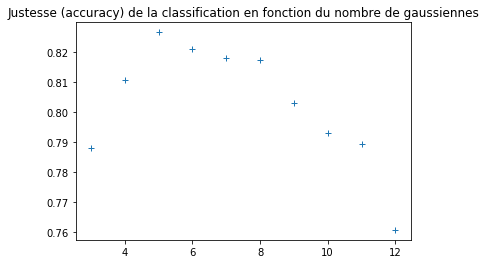

In [596]:
# accuracy vs nbr gaussiennes
accuracies = []
errors = []
for gmm in result:
    accuracies.append(gmm[0][0])
    errors.append(gmm[0][1])
plt.plot(nbr_gmm,accuracies,'o',marker='+')
#plt.plot(nbr_gmm,errors, 'ro')

plt.title('Justesse (accuracy) de la classification en fonction du nombre de gaussiennes')


In [588]:
nbr_gmm = np.arange(3,len(result)+3,1).tolist()

#critères pour croissants
Crprecisions = []
for gmm in result:
    Crprecisions.append(gmm[1][0])
Crrecalls = []
for gmm in result:
    Crrecalls.append(gmm[1][1])

Crf1s = []
for gmm in result:
    Crf1s.append(gmm[1][2])
    
#critères pour slippers
Slprecisions = []
for gmm in result:
    Slprecisions.append(gmm[2][0])
Slrecalls = []
for gmm in result:
    Slrecalls.append(gmm[2][1])

Slf1s = []
for gmm in result:
    Slf1s.append(gmm[2][2])


#critères pour other
Othprecisions = []
for gmm in result:
    Othprecisions.append(gmm[3][0])
Othrecalls = []
for gmm in result:
    Othrecalls.append(gmm[3][1])

Othf1s = []
for gmm in result:
    Othf1s.append(gmm[3][2])

Text(0.5, 1.0, 'Score F1 des others selon le nombre de gaussiennes')

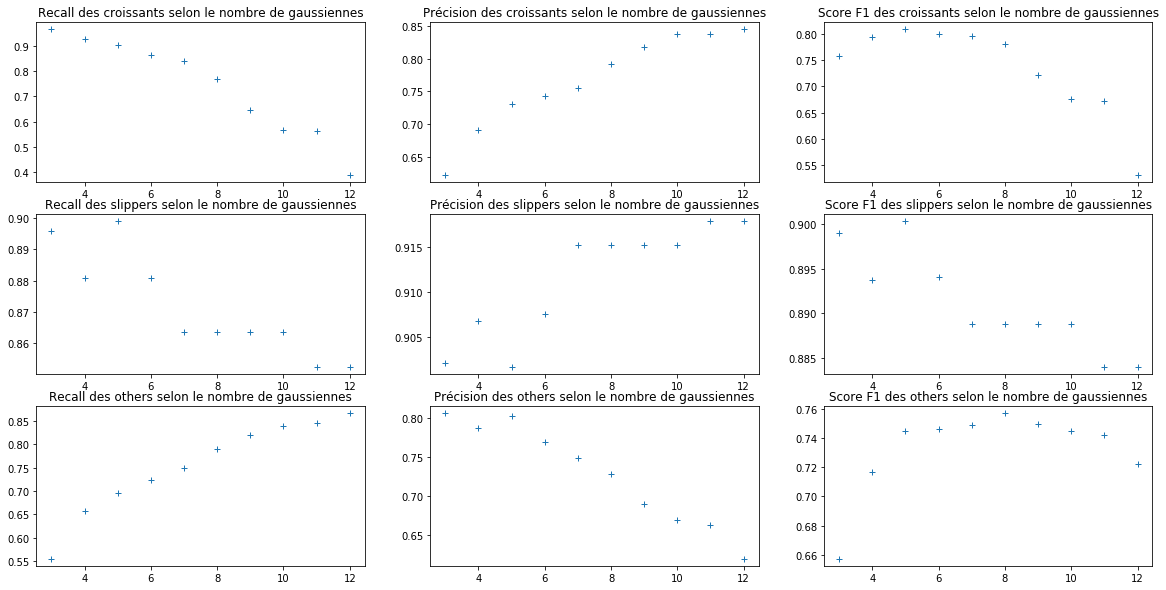

In [594]:
plt.figure(figsize=(20, 10))

plt.subplot(331)
plt.plot(nbr_gmm, Crrecalls,'o',marker='+')
plt.title('Recall des croissants selon le nombre de gaussiennes')
#plt.axis('off')
plt.subplot(332)
plt.plot(nbr_gmm, Crprecisions,'o',marker='+')
plt.title('Précision des croissants selon le nombre de gaussiennes')
#plt.axis('off')
plt.subplot(333)
plt.plot(nbr_gmm,Crf1s,'o',marker='+')
plt.title('Score F1 des croissants selon le nombre de gaussiennes')
#plt.axis('off')

#plt.figure(figsize=(20, 10))

plt.subplot(334)
plt.plot(nbr_gmm, Slrecalls,'o',marker='+')
plt.title('Recall des slippers selon le nombre de gaussiennes')
#plt.axis('off')
plt.subplot(335)
plt.plot(nbr_gmm, Slprecisions,'o',marker='+')
plt.title('Précision des slippers selon le nombre de gaussiennes')
#plt.axis('off')
plt.subplot(336)
plt.plot(nbr_gmm,Slf1s,'o',marker='+')
plt.title('Score F1 des slippers selon le nombre de gaussiennes')
#plt.axis('off')

#plt.figure(figsize=(20, 10))

plt.subplot(337)
plt.plot(nbr_gmm, Othrecalls,'o',marker='+')
plt.title('Recall des others selon le nombre de gaussiennes')
#plt.axis('off')
plt.subplot(338)
plt.plot(nbr_gmm, Othprecisions,'o',marker='+')
plt.title('Précision des others selon le nombre de gaussiennes')
#plt.axis('off')
plt.subplot(339)
plt.plot(nbr_gmm,Othf1s,'o',marker='+')
plt.title('Score F1 des others selon le nombre de gaussiennes')
#plt.axis('off')

In [ ]:
# data = {'apples': 10, 'oranges': 15, 'lemons': 5, 'limes': 20}
# names = list(data.keys())
# values = list(data.values())

# fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
# axs[0].bar(names, values)
# axs[1].scatter(names, values)
# axs[2].plot(names, values)
# fig.suptitle('Categorical Plotting')

### Analyse à 3 $\sigma$

In [655]:
result3sig = gmmAnalyisMisclass(predicted_test, labels_test,3)

Text(0.5, 1.0, 'Justesse (accuracy) de la classification en fonction du nombre de gaussiennes')

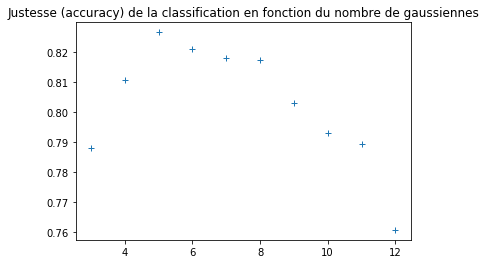

In [656]:
# accuracy vs nbr gaussiennes
accuracies = []
errors = []
for gmm in result:
    accuracies.append(gmm[0][0])
    errors.append(gmm[0][1])
plt.plot(nbr_gmm,accuracies,'o',marker='+')
#plt.plot(nbr_gmm,errors, 'ro')

plt.title('Justesse (accuracy) de la classification en fonction du nombre de gaussiennes')


In [654]:
nbr_gmm = np.arange(3,len(result)+3,1).tolist()

#critères pour croissants
Crprecisions = []
for gmm in result:
    Crprecisions.append(gmm[1][0])
Crrecalls = []
for gmm in result:
    Crrecalls.append(gmm[1][1])

Crf1s = []
for gmm in result:
    Crf1s.append(gmm[1][2])
    
#critères pour slippers
Slprecisions = []
for gmm in result:
    Slprecisions.append(gmm[2][0])
Slrecalls = []
for gmm in result:
    Slrecalls.append(gmm[2][1])

Slf1s = []
for gmm in result:
    Slf1s.append(gmm[2][2])


#critères pour other
Othprecisions = []
for gmm in result:
    Othprecisions.append(gmm[3][0])
Othrecalls = []
for gmm in result:
    Othrecalls.append(gmm[3][1])

Othf1s = []
for gmm in result:
    Othf1s.append(gmm[3][2])

[-71.26813875123658, 7.385962093073901]

Text(0.5, 1.0, 'Score F1 des others selon le nombre de gaussiennes')

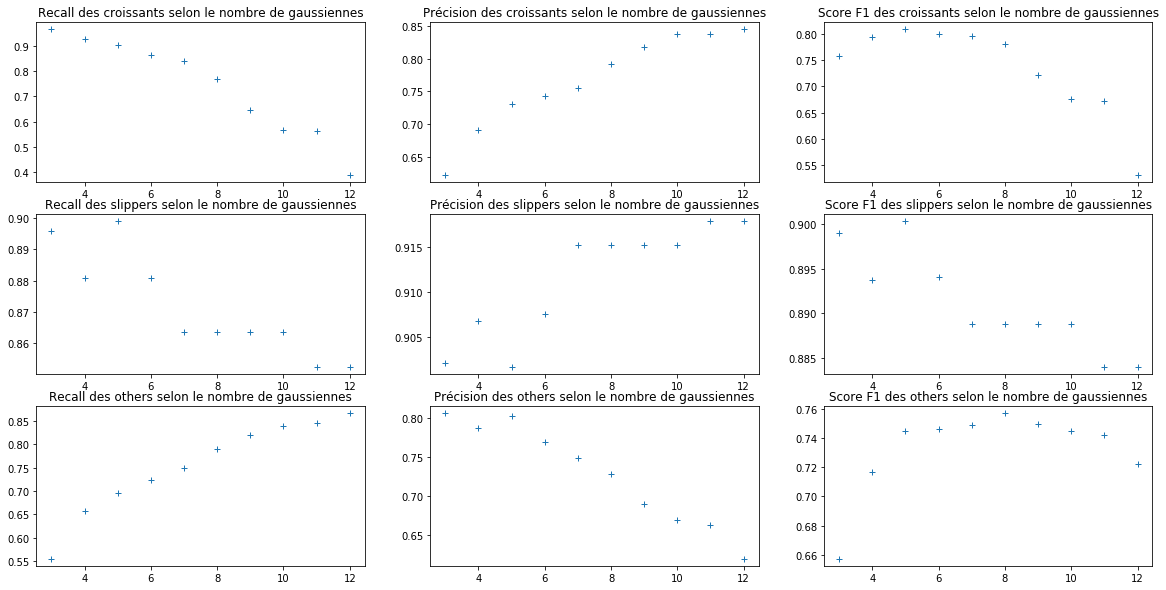

In [657]:
plt.figure(figsize=(20, 10))

plt.subplot(331)
plt.plot(nbr_gmm, Crrecalls,'o',marker='+')
plt.title('Recall des croissants selon le nombre de gaussiennes')
#plt.axis('off')
plt.subplot(332)
plt.plot(nbr_gmm, Crprecisions,'o',marker='+')
plt.title('Précision des croissants selon le nombre de gaussiennes')
#plt.axis('off')
plt.subplot(333)
plt.plot(nbr_gmm,Crf1s,'o',marker='+')
plt.title('Score F1 des croissants selon le nombre de gaussiennes')
#plt.axis('off')

#plt.figure(figsize=(20, 10))

plt.subplot(334)
plt.plot(nbr_gmm, Slrecalls,'o',marker='+')
plt.title('Recall des slippers selon le nombre de gaussiennes')
#plt.axis('off')
plt.subplot(335)
plt.plot(nbr_gmm, Slprecisions,'o',marker='+')
plt.title('Précision des slippers selon le nombre de gaussiennes')
#plt.axis('off')
plt.subplot(336)
plt.plot(nbr_gmm,Slf1s,'o',marker='+')
plt.title('Score F1 des slippers selon le nombre de gaussiennes')
#plt.axis('off')

#plt.figure(figsize=(20, 10))

plt.subplot(337)
plt.plot(nbr_gmm, Othrecalls,'o',marker='+')
plt.title('Recall des others selon le nombre de gaussiennes')
#plt.axis('off')
plt.subplot(338)
plt.plot(nbr_gmm, Othprecisions,'o',marker='+')
plt.title('Précision des others selon le nombre de gaussiennes')
#plt.axis('off')
plt.subplot(339)
plt.plot(nbr_gmm,Othf1s,'o',marker='+')
plt.title('Score F1 des others selon le nombre de gaussiennes')
#plt.axis('off')

### Etudier

* Shift de range
* Convergence training error : thresold over-fitting
* Ic threshold adapted : Cr : 2.5sig - Sli 3.5sig 

## Recherche d'un Ic optimal

In [804]:
grid = {'sigmaCr':np.arange(2,3.5,0.1),'sigmaSl':np.arange(2,3.5,0.1)}

In [805]:
grid

{'sigmaCr': array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,
        3.3, 3.4]),
 'sigmaSl': array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,
        3.3, 3.4])}

In [806]:
from sklearn.model_selection import ParameterGrid
len(list(ParameterGrid(grid)))   


225

In [ ]:
#ajout d'un index pour retrouver les paramètres de la grille e recherche

## Recherche pour un g=k donné

In [807]:
def intervalCGrid(searchGridSigma,k):
    
    result = []
    index = 0;
    for param in list(ParameterGrid(searchGridSigma)):
        sigmaCr = param['sigmaCr']
        sigmaSl = param['sigmaSl']
        gmm = mixture.GaussianMixture(n_components=k)
        g = gmm.fit(predicted_test)
        weights = g.weights_
        means = []
        means = g.means_
        covars = g.covariances_
        meanSl = min(means)[0]
        meanCr = max(means)[0]
        varSli = covars[np.where(means == min(means))][0][0]
        varCr = covars[np.where(means == max(means))][0][0]
        
        ## We got then the confidence interval
        paramSli = [(meanSl), (math.sqrt(varSli))]
        paramCr = [(meanCr), (math.sqrt(varCr))]
        sl = sigmaSl*math.sqrt(varSli)
        sC = sigmaCr*math.sqrt(varCr)
        intervalSli = []
        intervalSli.append(meanSl-sl)
        intervalSli.append(meanSl+sl)
        intervalCr = []
        intervalCr.append(meanCr-sC)
        intervalCr.append(meanCr+sC)
        ## predictions
        pred_labels = []

        for i in range(len(predicted_test)):
            if((predicted_test[i]>intervalCr[0])): #Croissants
                pred_labels.append(2)
            elif((predicted_test[i]<intervalSli[1])): #Slippers
                pred_labels.append(0)
            else: 
                pred_labels.append(1) #Other : if they fit in no confidence interval, we assume they are just "others"

        pred_labels = np.asarray(pred_labels)

        
        
        ## true labels
        true_labels = []
        for i in range(len(labels_test)):
            if(labels_test[i] == 'Slippers'):
                true_labels.append(0)
            elif(labels_test[i] == 'Croissants'):
                true_labels.append(2)
            else : 
                true_labels.append(1)

        true_labels = np.asarray(true_labels)
        
        
        
        #cm = confusion_matrix(y_true, y_pred, labels=labels)

        
        cm = confusion_matrix(true_labels, pred_labels, labels=[2, 0, 1])
                
        
        ## critères de perf
        
        tp = 0
        err = 0
        
        for i in range(len(cm)):
            for j in range(len(cm)):
                if i==j:
                    tp = cm[i][j] + tp
                else:
                    err = err + cm[i][j]
            
        
        acc_rate = tp /np.sum(cm)
        err_rate = err/np.sum(cm)
        
        
        res_acc = precision_recall_fscore_support(true_labels, pred_labels, 
                                beta=1.0, 
                                labels=[2,0,1], 
                                pos_label=1, 
                                average=None, 
                                warn_for=('precision', 'recall', 'f-score'), 
                                sample_weight=None)

        precision = res_acc[0]
        recall = res_acc[1]
        f1 = res_acc[2]
        gmm_res = []
        gmm_res.append([index,[acc_rate,err_rate]])
        for i in range(3):
                gmm_res.append([precision[i],recall[i],f1[i]])
        result.append(gmm_res)     
        index+=1
        
    return result    

In [809]:
resultGrid_g5 = intervalCGrid(grid,5)

In [800]:
resultGrid_g5

[[[0, [0.8233009708737864, 0.1766990291262136]],
  [0.7218788627935723, 0.906832298136646, 0.8038540949759119],
  [0.9026415094339623, 0.8952095808383234, 0.8989101841413002],
  [0.799163179916318, 0.6882882882882883, 0.739593417231365]],
 [[1, [0.8258899676375404, 0.17411003236245956]],
  [0.7275, 0.9037267080745341, 0.8060941828254847],
  [0.8969607116382505, 0.905688622754491, 0.9013035381750465],
  [0.8076514346439958, 0.6846846846846847, 0.7411019015114578]],
 [[2, [0.8255663430420712, 0.1744336569579288]],
  [0.7218788627935723, 0.906832298136646, 0.8038540949759119],
  [0.8954344624447718, 0.9101796407185628, 0.902746844840386],
  [0.8136511375947996, 0.6765765765765765, 0.7388096409247417]],
 [[3, [0.8252427184466019, 0.17475728155339806]],
  [0.7218788627935723, 0.906832298136646, 0.8038540949759119],
  [0.8896151053013798, 0.9169161676646707, 0.903059343899742],
  [0.8196902654867256, 0.6675675675675675, 0.7358490566037735]],
 [[4, [0.8258899676375404, 0.17411003236245956]],


### Meilleure modeles (g=5)

In [844]:
accuracy = []
averageRecall = []
averageF1 = []
for gmm in resultGrid_g5:
    ave = 0
    avef1 = 0
    avef1 = (gmm[1][2] + gmm[2][2] + gmm[3][2])/3
    ave = (gmm[1][1] + gmm[2][1] + gmm[3][1])/3
    averageRecall.append(ave)
    averageF1.append(avef1)
    accuracy.append(gmm[0][1][0])   
    

In [845]:
bestAccInd = accuracy.index(max(accuracy))

In [846]:
bestAvRecInd = averageRecall.index(max(averageRecall))

In [847]:
bestAvF1Ind = averageF1.index(max(averageF1))

In [848]:
resultGrid_g5[bestAvF1Ind]

[[4, [0.8288025889967637, 0.17119741100323624]],
 [0.7302383939774153, 0.9037267080745341, 0.8077723802914643],
 [0.8945054945054945, 0.9139221556886228, 0.904109589041096],
 [0.8168103448275862, 0.6828828828828829, 0.7438665358194307]]

In [849]:
resultGrid_g5[bestAccInd]

[[4, [0.8288025889967637, 0.17119741100323624]],
 [0.7302383939774153, 0.9037267080745341, 0.8077723802914643],
 [0.8945054945054945, 0.9139221556886228, 0.904109589041096],
 [0.8168103448275862, 0.6828828828828829, 0.7438665358194307]]

In [850]:
list(ParameterGrid(grid))[bestAccInd]

{'sigmaCr': 2.0, 'sigmaSl': 2.4000000000000004}

In [822]:
resultGrid_g5[bestAvRecInd]

[[4, [0.8288025889967637, 0.17119741100323624]],
 [0.7302383939774153, 0.9037267080745341, 0.8077723802914643],
 [0.8945054945054945, 0.9139221556886228, 0.904109589041096],
 [0.8168103448275862, 0.6828828828828829, 0.7438665358194307]]

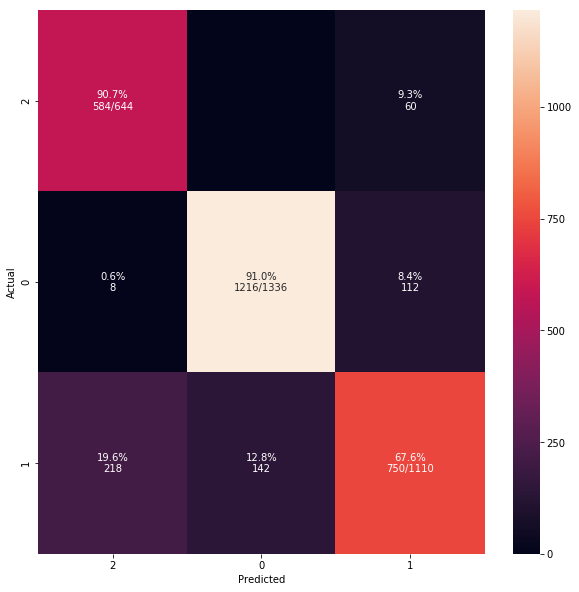

In [866]:
cm_analysis(true_labels, pred_labels, labels = [2,0,1])

### Meilleurs modeles (g=6)

In [823]:
resultGrid_g6 = intervalCGrid(grid,6)

In [824]:
accuracy = []
averageRecall = []
averageF1 = []
for gmm in resultGrid_g6:
    ave = 0
    avef1 = 0
    avef1 = (gmm[1][2] + gmm[2][2] + gmm[3][2])/3
    ave = (gmm[1][1] + gmm[2][1] + gmm[3][1])/3
    averageRecall.append(ave)
    averageF1.append(avef1)
    accuracy.append(gmm[0][1][0])   
    

In [825]:
bestAvF1Ind = averageF1.index(max(averageF1))

In [826]:
resultGrid_g6[bestAvF1Ind]

[[65, [0.8288025889967637, 0.17119741100323624]],
 [0.7377892030848329, 0.8913043478260869, 0.8073136427566807],
 [0.8955114054451803, 0.9109281437125748, 0.9031539888682747],
 [0.8079748163693599, 0.6936936936936937, 0.746485700436258]]

In [867]:
list(ParameterGrid(grid))[bestAvRecInd]

{'sigmaCr': 2.0, 'sigmaSl': 2.4000000000000004}

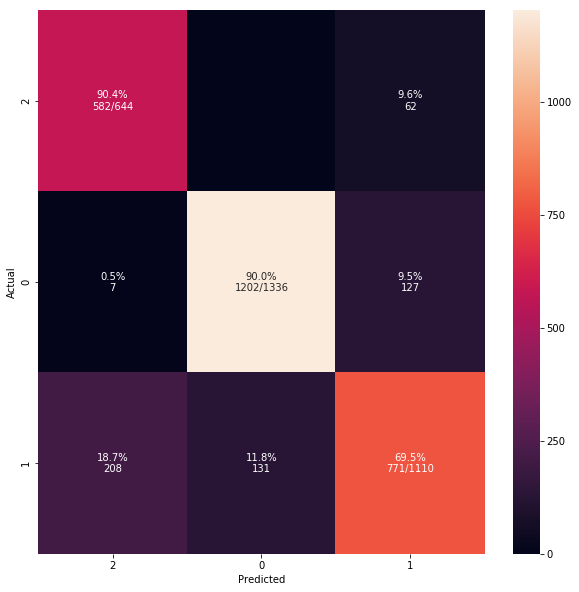

In [843]:
#best f1
cm_analysis(true_labels, pred_labels, labels = [2,0,1])

### Recherche totale

In [874]:
grid = {'sigmaCr':np.arange(2,3.5,0.1),'sigmaSl':np.arange(2,3.5,0.1),'g':np.arange(4,10)}

In [875]:
len(list(ParameterGrid(grid)))

1350

In [877]:
def intervalCGrid(searchGrid):
    
    result = []
    index = 0;
    for param in list(ParameterGrid(searchGrid)):
        sigmaCr = param['sigmaCr']
        sigmaSl = param['sigmaSl']
        k = param['g']
        gmm = mixture.GaussianMixture(n_components=k)
        g = gmm.fit(predicted_test)
        weights = g.weights_
        means = []
        means = g.means_
        covars = g.covariances_
        meanSl = min(means)[0]
        meanCr = max(means)[0]
        varSli = covars[np.where(means == min(means))][0][0]
        varCr = covars[np.where(means == max(means))][0][0]
        
        ## We got then the confidence interval
        paramSli = [(meanSl), (math.sqrt(varSli))]
        paramCr = [(meanCr), (math.sqrt(varCr))]
        sl = sigmaSl*math.sqrt(varSli)
        sC = sigmaCr*math.sqrt(varCr)
        intervalSli = []
        intervalSli.append(meanSl-sl)
        intervalSli.append(meanSl+sl)
        intervalCr = []
        intervalCr.append(meanCr-sC)
        intervalCr.append(meanCr+sC)
        ## predictions
        pred_labels = []

        for i in range(len(predicted_test)):
            if((predicted_test[i]>intervalCr[0])): #Croissants
                pred_labels.append(2)
            elif((predicted_test[i]<intervalSli[1])): #Slippers
                pred_labels.append(0)
            else: 
                pred_labels.append(1) #Other : if they fit in no confidence interval, we assume they are just "others"

        pred_labels = np.asarray(pred_labels)

        
        
        ## true labels
        true_labels = []
        for i in range(len(labels_test)):
            if(labels_test[i] == 'Slippers'):
                true_labels.append(0)
            elif(labels_test[i] == 'Croissants'):
                true_labels.append(2)
            else : 
                true_labels.append(1)

        true_labels = np.asarray(true_labels)
        
        
        
        #cm = confusion_matrix(y_true, y_pred, labels=labels)

        
        cm = confusion_matrix(true_labels, pred_labels, labels=[2, 0, 1])
                
        
        ## critères de perf
        
        tp = 0
        err = 0
        
        for i in range(len(cm)):
            for j in range(len(cm)):
                if i==j:
                    tp = cm[i][j] + tp
                else:
                    err = err + cm[i][j]
            
        
        acc_rate = tp /np.sum(cm)
        err_rate = err/np.sum(cm)
        
        
        res_acc = precision_recall_fscore_support(true_labels, pred_labels, 
                                beta=1.0, 
                                labels=[2,0,1], 
                                pos_label=1, 
                                average=None, 
                                warn_for=('precision', 'recall', 'f-score'), 
                                sample_weight=None)

        precision = res_acc[0]
        recall = res_acc[1]
        f1 = res_acc[2]
        gmm_res = []
        gmm_res.append([index,[acc_rate,err_rate]])
        for i in range(3):
                gmm_res.append([precision[i],recall[i],f1[i]])
        result.append(gmm_res)     
        index+=1
        
    return result    

In [878]:
resultGrid = intervalCGrid(grid)

In [911]:
accuracy = []
averageRecall = []
averageF1 = []
averagePres = []
for gmm in resultGrid:
    ave = 0
    avef1 = 0
    aveP =  (gmm[1][0] + gmm[2][0] + gmm[3][0])/3
    avef1 = (gmm[1][2] + gmm[2][2] + gmm[3][2])/3
    ave = (gmm[1][1] + gmm[2][1] + gmm[3][1])/3
    averageRecall.append(ave)
    averagePres.append(aveP)
    averageF1.append(avef1)
    accuracy.append(gmm[0][1][0])  
    
bestAvF1Ind = averageF1.index(max(averageF1))
list(ParameterGrid(grid))[bestAvF1Ind]

{'g': 7, 'sigmaCr': 2.5000000000000004, 'sigmaSl': 2.5000000000000004}

### Meilleure Précision globale

In [913]:
bestPresInd = averagePres.index(max(averagePres))
resultGrid[bestPresInd]

[[1159, [0.8245954692556634, 0.17540453074433657]],
 [0.7976973684210527, 0.7531055900621118, 0.7747603833865815],
 [0.9012715033657442, 0.9019461077844312, 0.9016086793864572],
 [0.7493449781659388, 0.772972972972973, 0.7609756097560975]]

In [914]:
list(ParameterGrid(grid))[bestPresInd]

{'g': 9, 'sigmaCr': 2.2, 'sigmaSl': 2.4000000000000004}

In [ ]:
bestAccInd = accuracy.index(max(average))
resultGrid[bestAccInd]

### Meilleur F1 global

In [910]:
list(ParameterGrid(grid))[bestAvF1Ind]

{'g': 7, 'sigmaCr': 2.5000000000000004, 'sigmaSl': 2.5000000000000004}

### Meilleure Accuracy globale

In [882]:
list(ParameterGrid(grid))[bestAccInd]

{'g': 7, 'sigmaCr': 2.6000000000000005, 'sigmaSl': 3.200000000000001}

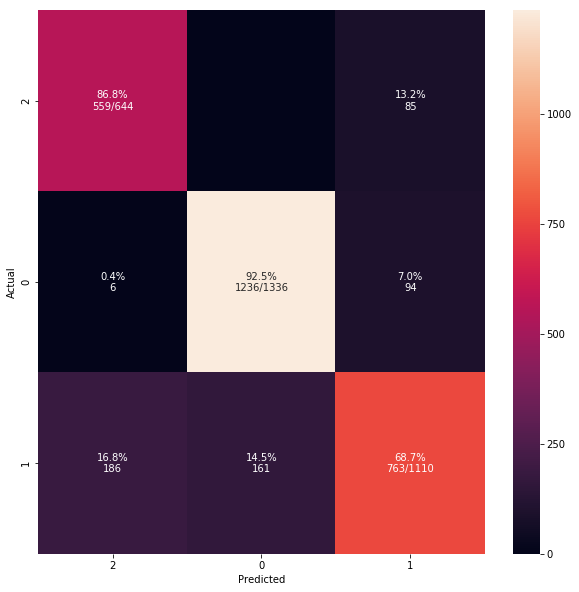

In [908]:
#{'g': 7, 'sigmaCr': 2.6000000000000005, 'sigmaSl': 3.200000000000001}
#best accuracy
cm_analysis(true_labels, pred_labels, labels = [2,0,1])

In [883]:
resultGrid[bestAccInd]

[[777, [0.8288025889967637, 0.17119741100323624]],
 [0.7368421052631579, 0.8913043478260869, 0.8067463106113842],
 [0.8853868194842407, 0.9251497005988024, 0.9048316251830161],
 [0.8207650273224044, 0.6765765765765765, 0.7417283950617284]]

In [918]:
#fonction pour afficher la matrice directement
def displayConfusionFromGmm(predicted_test,labels_test,g,icCr,icSli):

    # gmm = mixture.GaussianMixture(n_components=3, covariance_type='spherical')
    gmm = mixture.GaussianMixture(n_components=g)
    g = gmm.fit(predicted_test)

    weights = g.weights_
    means = []
    means = g.means_
    covars = g.covariances_
    
    meanSl = min(means)[0]
    meanCr = max(means)[0]
    
    varSli = covars[np.where(means == min(means))][0][0]
    varCr = covars[np.where(means == max(means))][0][0]

    paramSli = [(meanSl), (math.sqrt(varSli))]
    paramCr = [(meanCr), (math.sqrt(varCr))]

    sl = math.sqrt(varSli)
    sC = math.sqrt(varCr)


    intervalSli = []
    intervalSli.append(meanSl-icSli*sl)
    intervalSli.append(meanSl+icSli*sl)
    intervalCr = []
    intervalCr.append(meanCr-icCr*sC)
    intervalCr.append(meanCr+icCr*sC)

    true_labels = []
    for i in range(len(labels_test)):
        if(labels_test[i] == 'Slippers'):
            true_labels.append(0)
        elif(labels_test[i] == 'Croissants'):
            true_labels.append(2)
        else : 
            true_labels.append(1)

    true_labels = np.asarray(true_labels)

    pred_labels = []

    for k in range(len(predicted_test)):
        if((predicted_test[k]>intervalCr[0])): #Croissants
            pred_labels.append(2)
        elif((predicted_test[k]<intervalSli[1])): #Slippers

            pred_labels.append(0)
        else: 
            pred_labels.append(1) #Other 

    pred_labels = np.asarray(pred_labels)
    

    return(cm_analysis(true_labels, pred_labels, labels = [2,0,1]))


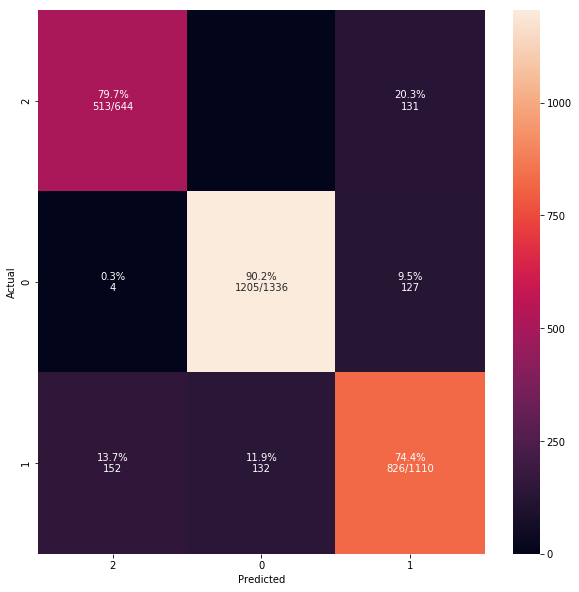

In [921]:
displayConfusionFromGmm(predicted_test,labels_test,8,2.3,2.5)